In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 15)
# 
# d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/")

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/100train")

2017-04-10 13:47:39,902 : INFO : Loading serialized wrapper model from: trained_models/wrapper/100train
2017-04-10 13:47:39,903 : INFO : Loading docs objects
2017-04-10 13:47:47,090 : INFO : Loading trained Doc2Vec model
2017-04-10 13:47:47,091 : INFO : loading Doc2Vec object from trained_models/wrapper/100traindoc2vec.mod
2017-04-10 13:47:47,389 : INFO : loading docvecs recursively from trained_models/wrapper/100traindoc2vec.mod.docvecs.* with mmap=None
2017-04-10 13:47:47,389 : INFO : loading doctag_syn0 from trained_models/wrapper/100traindoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-04-10 13:47:47,761 : INFO : loading syn1neg from trained_models/wrapper/100traindoc2vec.mod.syn1neg.npy with mmap=None
2017-04-10 13:47:47,973 : INFO : loading syn0 from trained_models/wrapper/100traindoc2vec.mod.syn0.npy with mmap=None
2017-04-10 13:47:48,233 : INFO : setting ignored attribute syn0norm to None
2017-04-10 13:47:48,234 : INFO : setting ignored attribute cum_table to None


In [5]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-10 13:47:58,941 : INFO : Docs vector inference started
2017-04-10 13:47:58,942 : INFO : Inferring vectors of 43395 documents


In [6]:
d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/100epoch_train_nostem")

2017-04-10 13:56:50,373 : INFO : Serializing wrapper model to: trained_models/wrapper/100epoch_train_nostem
2017-04-10 13:56:50,374 : INFO : Persisting docs objects
2017-04-10 13:56:58,187 : INFO : Persisting inferred vectors
2017-04-10 13:57:20,620 : INFO : Persisting trained Doc2Vec model
2017-04-10 13:57:20,621 : INFO : saving Doc2Vec object under trained_models/wrapper/100epoch_train_nostemdoc2vec.mod, separately None
2017-04-10 13:57:20,622 : INFO : storing numpy array 'doctag_syn0' to trained_models/wrapper/100epoch_train_nostemdoc2vec.mod.docvecs.doctag_syn0.npy
2017-04-10 13:57:21,986 : INFO : storing numpy array 'syn1neg' to trained_models/wrapper/100epoch_train_nostemdoc2vec.mod.syn1neg.npy
2017-04-10 13:57:22,654 : INFO : not storing attribute syn0norm
2017-04-10 13:57:22,655 : INFO : storing numpy array 'syn0' to trained_models/wrapper/100epoch_train_nostemdoc2vec.mod.syn0.npy
2017-04-10 13:57:23,486 : INFO : not storing attribute cum_table


In [8]:
doc_labels.describe()

count     43395
unique       14
top         eap
freq      18355
Name: y, dtype: object

In [8]:
# classifier training and eval:
from sklearn.svm import SVC

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=5 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    logging.info("Shuffling indices")
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)

    # training
    # kernels to try: linear, poly, rbf, sigmoid
    svm_classifier = SVC(kernel="rbf", decision_function_shape="ovo", C=8, gamma=0.0025, probability=True)
    
    logging.info("Fitting classifier")
    svm_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])

    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = svm_classifier.predict(doc_vectors.iloc[test_doc_indices])

    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = svm_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(svm_classifier.classes_)

    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)), (class_actual_index)]

    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)), (class_expected_index)]

    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)

    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-04-11 09:05:03,265 : INFO : Shuffling indices
2017-04-11 09:05:03,284 : INFO : Fitting classifier
2017-04-11 09:30:17,339 : INFO : Predicting
2017-04-11 09:31:25,528 : INFO : Probs collection
2017-04-11 09:32:31,914 : INFO : Split results:
2017-04-11 09:32:31,920 : INFO : Run accuracy: 0.836020267158
2017-04-11 09:32:31,926 : INFO : Cat accuracies:
[0.224, 0.9261781530918006, 0.281767955801105, 0.3157894736842105, 0.8481824661439772, 0.4658119658119658, 0.48205128205128206, 0.7830045523520486, 0.0, 0.0, 0.9238385376999239, 0.0, 0.2857142857142857, 0.7868649318463445]
2017-04-11 09:32:31,928 : INFO : Shuffling indices
2017-04-11 09:32:31,953 : INFO : Fitting classifier
2017-04-11 09:54:08,803 : INFO : Predicting
2017-04-11 09:55:07,156 : INFO : Probs collection
2017-04-11 09:56:05,495 : INFO : Split results:
2017-04-11 09:56:05,501 : INFO : Run accuracy: 0.840456168644
2017-04-11 09:56:05,506 : INFO : Cat accuracies:
[0.256, 0.9313538545355489, 0.20441988950276244, 0.29824561403508

In [9]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-11 13:14:09,533 : INFO : split accuracies: [0.83602026715799171, 0.84045616864416539, 0.84017054620880383, 0.84165033997925554, 0.83619596541786745]
2017-04-11 13:14:09,604 : INFO : mean accuracy: 0.838898657482
2017-04-11 13:14:09,781 : INFO : categories accuracies: 
     amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.224  0.926178   0.281768  0.315789  0.848182  0.465812  0.482051   
0  0.256  0.931354   0.204420  0.298246  0.857448  0.480687  0.548718   
0  0.312  0.931899   0.237569  0.421053  0.828225  0.476395  0.635897   
0  0.272  0.931626   0.270718  0.456140  0.858161  0.472103  0.530928   
0  0.240  0.929175   0.266667  0.403509  0.851033  0.450644  0.515464   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.783005  0.000000               0.0  0.923839                  0.0   
0   0.772036  0.000000               0.0  0.929170                  0.0   
0   0.778116  0.071429               0.0  0.919970         

In [10]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.029670,69
12,mobileplatform,0.287143,101
3,datagrid,0.378947,285
0,amq,0.260800,625
2,webserver,0.252228,904
6,bpmsuite,0.542612,973
5,brms,0.469128,1166
7,devstudio,0.771495,3291


In [11]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
correct_logits.head(25)

,actual_prob,expected_prob,actual_class,expected_class
0,0.816850,0.009927,eap,brms
1,0.978756,0.978756,eap,eap
2,0.894475,0.894475,openshift,openshift
3,0.880951,0.018636,fuse,eap
4,0.827671,0.827671,rhel,rhel
5,0.724488,0.724488,devstudio,devstudio
6,0.909547,0.909547,eap,eap
7,0.317338,0.177272,eap,rhel
8,0.976692,0.976692,eap,eap
9,0.996760,0.996760,eap,eap


In [12]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = correct_logits[correct_logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['brms', 'eap', 'openshift', 'rhel', 'devstudio', 'fuse'], dtype=object)

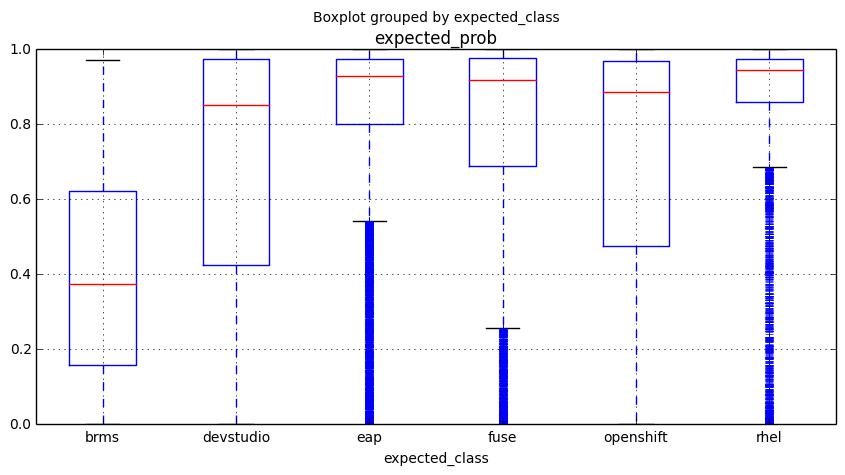

In [13]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [15]:
# TODO: classification needs to be done again
# incorrect classification characteristics
wrong_docs_ids = correct_logits[correct_logits["expected_class"] != correct_logits["actual_class"]]["doc_id"]

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

KeyError: 'doc_id'

In [20]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.all_content_tagged_docs.iloc[doc_id].words)
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    36657.000000
mean       135.858390
std        487.444108
min         10.000000
25%         26.000000
50%         41.000000
75%        105.000000
max      56006.000000
dtype: float64